In [1]:
import re
from collections import Counter
from typing import List, Tuple

import pandas as pd
import numpy as np
import spacy
import seaborn as sns
from scipy.spatial.distance import cosine

# download the first time
# !spacy download "en_core_web_sm"

## 1. import data

In [12]:
DATA_PATH = "../data/interim/targets_data.csv"
df = pd.read_csv(DATA_PATH)

pd.set_option("display.max_colwidth", None)

df['Date of Event'] = df['Date of Event'].astype(int, errors='ignore')  

columns_drop = [
    "Who's Adding the Target", 
    'Date of Entry', 
    # 'Target ID', 
    # 'Document ID',
    # 'Country Name', 
    # 'GHG/NON-GHG', 
    # 'Sector', 
    # 'Target Scope', 
    # 'Target Type',   
    # 'Is Target Per Capita?', 
    'Target Summary', 
    # 'Target Description',
    'Target Signals', 
    # 'Target Page Number',
    'Page Numbers: PDF or Document?', 
    'Target Base Year Period',
    'Target Year', 
    'Single or Multi-Year Target', 
    # 'Date of Event',
    'Comments / Further Information - instruments, errors, etc'
]

df = df.drop(columns=columns_drop)

df_not_targets = df[~df['is_target']]
df = df[df['is_target']]

In [13]:
rnd_seed = 142
nlp = spacy.load("en_core_web_sm")

## 2. EDA

### 2.1 descriptive statistics

In [14]:
print(f"Total num targets: {len(df)}")

duplicates = df.loc[df.duplicated('Target Description'), 'Target Description']
print(f"Duplicated targets: {len(duplicates.unique())} ({len(duplicates)} if counting duplicates as separate targets)" )

Total num targets: 353
Duplicated targets: 16 (24 if counting duplicates as separate targets)


**for the rest of this notebook we drop rows with duplicate target text**

In [15]:
df = df.drop_duplicates(subset='Target Description')
len(df)

329

### 2.2 years and year ranges

> about 50% of targets contain mentions of years. 22 (7%) of these year mentions are year ranges rather than individual years

In [21]:
def get_years(val: str) -> bool:
    # exclude vals=0: there is a 3,0000 figure in the data
    return [int(i) for i in re.findall(r"\d{4}", val) if 0 < int(i) < 2100]

def contains_year_range(val: str) -> bool:
    return bool(
        # 2008-9 or 2009-10 or 2009-2010
        re.findall(r"\d{4}-\d{1,2}", val) + re.findall(r"\d{4}-\d{4}", val) + re.findall(r"\d{4} to \d{4}", val)
    )

df['_years'] = df["Target Description"].apply(get_years)
df["_contains_year"] = df['_years'].apply(bool)
df['_max_year'] = df['_years'].apply(lambda l: max(l) if l else np.nan)
df['_max_year_ge_doc_created'] = df['_max_year'] >= df['Date of Event']
df['_contains_year_range'] = df["Target Description"].apply(contains_year_range)

df.groupby(["_contains_year", "_contains_year_range"]).count()["Target Description"]

_contains_year  _contains_year_range
False           False                   155
True            False                   152
                True                     22
Name: Target Description, dtype: int64

> most targets contain (max) years that are in the future. Where they don't, this tends to be a metadata issue (e.g. a document is a later revision) or because the year isn't the target year. Often, non-target years are years contained in titles of other policies that are mentioned.

_max_year_ge_doc_created
False     14
True     132
Name: Document ID, dtype: int64

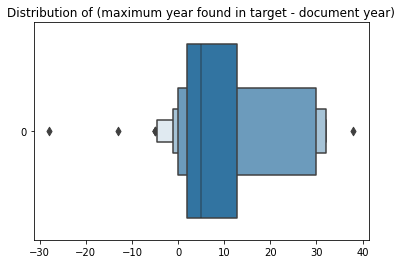

In [29]:
display(df[df['_contains_year'] & df['Date of Event']].groupby('_max_year_ge_doc_created').count()["Document ID"])

sns.boxenplot(data=df['_max_year'] - df["Date of Event"], orient="h").set_title("Distribution of (maximum year found in target - document year)");

### 2.3 figures that aren't years

> most targets contain a numerical non-year value (date, cardinal, quantity or percent) - there are some false negatives in this count too

In [31]:
ent_types = ("DATE", "CARDINAL", "QUANTITY", "PERCENT", "ORDINAL")

ent_col_names = []
ent_bool_col_names = []

for idx, row in df.iterrows():
    doc = nlp(row["Target Description"])
    
    for ent_type in ent_types:
        # exclude years
        ent_vals = [ent.text for ent in doc.ents if ent.label_ == ent_type if not get_years(ent.text)]
        
        col_name = f"_ents_{ent_type.lower()}"
        ent_col_names.append(col_name)
        df.at[idx, col_name] = ent_vals or np.nan
        
    df.at[idx, "_n_sentences"] = len(list(doc.sents))
    
for ent_type in ent_types:
    boolean_col_name = f'_contains_{ent_type.lower()}_ent'
    ent_bool_col_names.append(boolean_col_name)
    
    df[boolean_col_name] = df[f'_ents_{ent_type.lower()}'].notnull()
    display(df.groupby(boolean_col_name).count()["Document ID"])
    
# maximum and minimum
print("------------------------------")
for v in ("minimum", "maximum"):
    bool_col = f'_contains_{v}'
    df[bool_col] = df['Target Description'].apply(lambda i: v in i.lower())

    display(df.groupby(bool_col).count()["Document ID"])

_contains_date_ent
False    298
True      31
Name: Document ID, dtype: int64

_contains_cardinal_ent
False    190
True     139
Name: Document ID, dtype: int64

_contains_quantity_ent
False    316
True      13
Name: Document ID, dtype: int64

_contains_percent_ent
False    188
True     141
Name: Document ID, dtype: int64

_contains_ordinal_ent
False    317
True      12
Name: Document ID, dtype: int64

------------------------------


_contains_minimum
False    315
True      14
Name: Document ID, dtype: int64

_contains_maximum
False    328
True       1
Name: Document ID, dtype: int64

> targets that contain combinations of numerical entities are most likely to contain a combination of cardinal and percent figures, followed by percent and date figures

<AxesSubplot:>

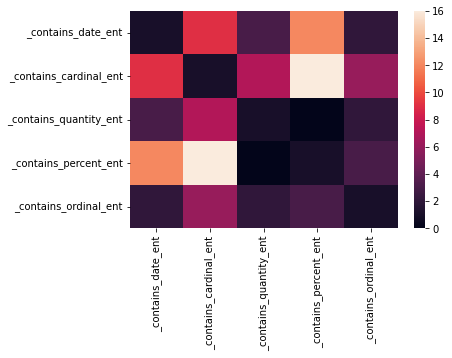

In [32]:
sns.heatmap(df[ent_bool_col_names].corr(method=np.dot))

> most of the non-year dates talk mention 'annual(ly)' or 'n years'

In [33]:
sorted(df.loc[df['_contains_date_ent'], "_ents_date"].sum())

['15 years',
 '5 years',
 '5 years',
 '5 years',
 '80 years',
 'Annually',
 'Five Year Plan',
 'Monthly',
 'The target year',
 'a year',
 'annual',
 'annual',
 'annual',
 'annual',
 'annually',
 'annually',
 'close to 80 years',
 'five years',
 'five-year',
 'five-year',
 'that year',
 'that year',
 'the 75th year',
 'the current year',
 'the end of the',
 'the next 5 years',
 'the next five years',
 'the next five years',
 'the next five years',
 'the year',
 'the year',
 'the year',
 'those years',
 'today']

### 2.4 Number of sentences

> most targets are 1 sentence long

In [34]:
df.groupby(["_n_sentences"]).count()["Document ID"]

_n_sentences
1.0    305
2.0     22
3.0      2
Name: Document ID, dtype: int64

> *"Construction of perinatal center in Bishkek funded by the German Government"* target seems to be lacking context?

In [35]:
# some targets with 3 or 2 sentences
df.sort_values('_n_sentences', ascending=False).head(5)[[col for col in df.columns if not col.startswith("_")]]

,Target ID,Document ID,Country Name,GHG/NON-GHG,Sector,Target Scope,Target Type,Is Target Per Capita?,Target Description,Target Page Number,Date of Event,Target Description (original language),is_target
189,167.0,9532,Bhutan,GHG,Economy-wide,Carbon neutrality,Fixed level target,No,"Carbon Neutral Declaration: The “Declaration of the Kingdom of Bhutan - The Land of Gross National Happiness to Save our Planet” made by the Kingdom of Bhutan in 2009 and reaffirmed in 2015 is a unilateral declaration and may have the status of international customary law. Therefore, as far as the obligations of Bhutan are concerned; the commitment to ensure GHG emissions remain below forest sinks must be fulfilled.",10,2020.0,NaN,True
81,66.0,10368,Kyrgyzstan,Non-GHG,Health,Health services,Fixed level target,No,Construction of perinatal center in Bishkek funded by the German Government. ✓ Construction of neurosurgical center of the National Hospital of the Ministry of Health of the Kyrgyz Republic. ✓ Construction of the surgical building of the city children’s clinical emergency hospital.,112,2018.0,NaN,True
202,167.0,10222,Bhutan,GHG,Economy-wide,Carbon neutrality,Fixed level target,No,STRATEGIC OBJECTIVE 9: REMAIN CARBON NEUTRAL,61,2019.0,NaN,True
34,19.0,9741,India,GHG,Economy-wide,Energy intensity,Intensity target,No,the NDC has eight goals including three quantitative goals viz. reduction in the emissions intensity of Gross Domestic Product (GDP) by 33 to 35 per cent by 2030 from 2005 level,4,2020.0,NaN,True
119,104.0,10368,Kyrgyzstan,Non-GHG,Health,Health services,Fixed level target,No,✓ Modernization of 21 family medicine centers and equipping them with modern equipment. ✓ Modernization of multidisciplinary hospital with modern equipment for high-level emergency care.,121,2018.0,NaN,True


### 2.5 common ngrams

In [36]:
import string
import random
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

# input the reuters sentences
sents = df['Target Description'].tolist()
 
# write the removal characters such as : Stopwords and punctuation
stop_words = set(stopwords.words('english'))
punctuation = string.punctuation

tokens_remove = list(stop_words) + list(punctuation)

def process_sentence(sent: str) -> str:
    """Remove stopwords and punctuation"""
    
    return " ".join([tok for tok in word_tokenize(sent) if tok not in tokens_remove])
    
def get_ngrams(sentence: str, n: int) -> List[Tuple[str]]:
    sent_split = sentence.lower().split()
    
    if n == 1:
        return sent_split
    else:
        return list(ngrams(
            sent_split, 
            n, 
            pad_left=False, 
            pad_right=False,
        ))
    
df['_target_no_stopwords'] = df['Target Description'].apply(process_sentence)
df[['_unigrams', '_bigrams', '_trigrams']] = ""

for idx, row in df.iterrows():
    unigrams = get_ngrams(row["_target_no_stopwords"], 1)
    bigrams = get_ngrams(row["_target_no_stopwords"], 2)
    trigrams = get_ngrams(row["_target_no_stopwords"], 3)
    
    df.at[idx, '_unigrams'] = unigrams
    df.at[idx, '_bigrams'] = bigrams
    df.at[idx, '_trigrams'] = trigrams

all_unigrams = df['_unigrams'].sum()
all_bigrams = df['_bigrams'].sum()
all_trigrams = df['_trigrams'].sum()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kalyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


> the most common ngrams seem to be overfitting to the longest document in the dataset

In [37]:
print("unigrams")
display(Counter(all_unigrams).most_common(10))

print("\nbigrams")
display(Counter(all_bigrams).most_common(10))

print("\ntrigrams")
display(Counter(all_trigrams).most_common(10))


unigrams


[('energy', 95),
 ('the', 61),
 ('✓', 49),
 ('2030', 48),
 ('renewable', 38),
 ('least', 37),
 ('2050', 35),
 ('new', 34),
 ('reduction', 34),
 ('objective', 30)]


bigrams


[(('energy', 'consumption'), 20),
 (('renewable', 'energy'), 16),
 (('water', 'supply'), 13),
 (('specific', 'energy'), 13),
 (('drinking', 'water'), 12),
 (('✓', 'construction'), 12),
 (('✓', 'modernization'), 12),
 (('modern', 'equipment'), 12),
 (('irrigated', 'land'), 11),
 (('climate', 'neutrality'), 11)]


trigrams


[(('new', 'irrigated', 'land'), 9),
 (('hectares', 'new', 'irrigated'), 8),
 (('specific', 'energy', 'consumption'), 8),
 (('family', 'medicine', 'centers'), 7),
 (('social', 'assistance', 'centers'), 7),
 (('assistance', 'centers', 'disadvantaged'), 7),
 (('centers', 'disadvantaged', 'families'), 7),
 (('disadvantaged', 'families', 'children'), 7),
 (('families', 'children', 'centers'), 7),
 (('children', 'centers', 'responsible'), 7)]

#### ngrams containing years

> the informative trigrams (*2015 baseline*, *2030 relative*) once again seem to be specific to the same set of targets

In [38]:
bigrams_with_year = [g for g in all_bigrams if any([re.match(r"\d{4}", word) for word in g])]
trigrams_with_year = [g for g in all_trigrams if any([re.match(r"\d{4}", word) for word in g])]

print("bigrams containing year")
display(Counter(bigrams_with_year).most_common(10))

print("\ntrigrams containing year")
display(Counter(trigrams_with_year).most_common(10))

bigrams containing year


[(('compared', '1990'), 11),
 (('neutrality', '2050'), 7),
 (('relative', '2015'), 6),
 (('2015', 'baseline'), 6),
 (('by', '2040'), 6),
 (('20', '2030'), 5),
 (('2030', 'relative'), 5),
 (('by', '2023'), 4),
 (('later', '2050'), 4),
 (('set', '2019-20'), 3)]


trigrams containing year


[(('relative', '2015', 'baseline'), 6),
 (('2030', 'relative', '2015'), 5),
 (('climatic', 'neutrality', '2050'), 5),
 (('neutrality', 'later', '2050'), 3),
 (('90', 'compared', '1990'), 3),
 (('2030', "'s", 'horizon'), 3),
 (('corporation', 'set', '2019-2020'), 2),
 (('rural', 'households', '2024'), 2),
 (('new', 'clusters', '2019-20'), 2),
 (('incubators', 'tbis', '2019-20'), 2)]

#### ngram frequency split by GHG/non-GHG

> words and phrases like 'carbon neutral(ity)' seem to indicate that a phrase is a greenhouse gas target. However, this is unlikely to be a useful predictor for whether any phrase is a target.

In [39]:
df.groupby("GHG/NON-GHG").count()["Document ID"]

GHG/NON-GHG
GHG         39
Non-GHG    290
Name: Document ID, dtype: int64

In [40]:
for ghg_val in ("GHG", "Non-GHG"):
    print(ghg_val)
    display(Counter(df.loc[df['GHG/NON-GHG'] == ghg_val, "_unigrams"].sum()).most_common(10))
    display(Counter(df.loc[df['GHG/NON-GHG'] == ghg_val, "_bigrams"].sum()).most_common(10))
    print()

GHG


[('neutrality', 22),
 ('2050', 22),
 ('emissions', 18),
 ('carbon', 15),
 ('climate', 15),
 ('reduction', 13),
 ('the', 12),
 ('compared', 12),
 ('1990', 11),
 ('2030', 10)]

[(('climate', 'neutrality'), 11),
 (('compared', '1990'), 11),
 (('carbon', 'neutral'), 7),
 (('neutrality', '2050'), 7),
 (('greenhouse', 'gas'), 7),
 (('achieve', 'climate'), 6),
 (('climatic', 'neutrality'), 6),
 (('gas', 'emissions'), 6),
 (('carbon', 'neutrality'), 5),
 (('remain', 'carbon'), 5)]


Non-GHG


[('energy', 88),
 ('the', 49),
 ('✓', 49),
 ('2030', 38),
 ('renewable', 37),
 ('new', 32),
 ('least', 31),
 ('electricity', 29),
 ('consumption', 29),
 ('water', 28)]

[(('energy', 'consumption'), 20),
 (('renewable', 'energy'), 16),
 (('water', 'supply'), 13),
 (('specific', 'energy'), 13),
 (('drinking', 'water'), 12),
 (('✓', 'construction'), 12),
 (('✓', 'modernization'), 12),
 (('modern', 'equipment'), 12),
 (('irrigated', 'land'), 11),
 (('thousand', 'hectares'), 10)]